# Importation des packages

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [47]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [49]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()




,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

In [54]:
# Affichage des informations sur les colonnes et les types de données
data.info()
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


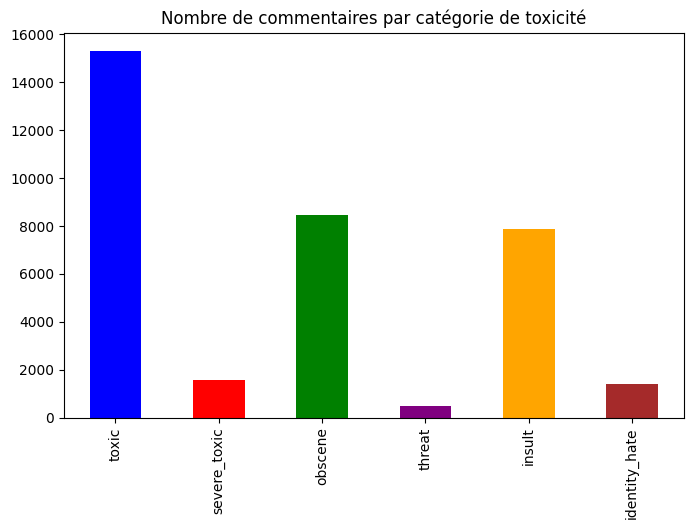

In [50]:
#Compter les occurrences de chaque classe
label_counts = data.iloc[:, 2:].sum()

#Affichage en barres
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'red', 'green', 'purple', 'orange', 'brown'])
plt.title("Nombre de commentaires par catégorie de toxicité")
plt.show()


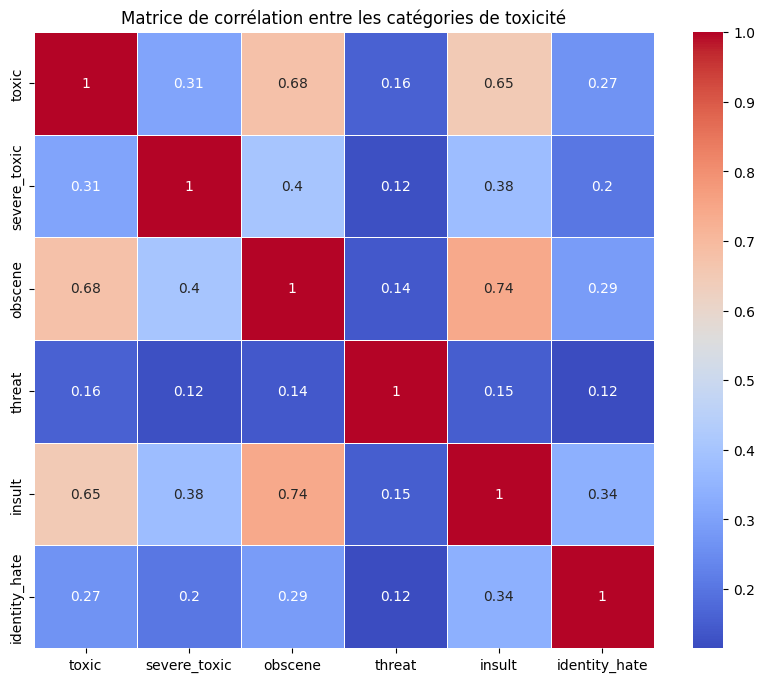

In [51]:
# Calculer la corrélation entre les colonnes de toxicité
correlation = data.iloc[:, 2:].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation entre les catégories de toxicité")
plt.show()


count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


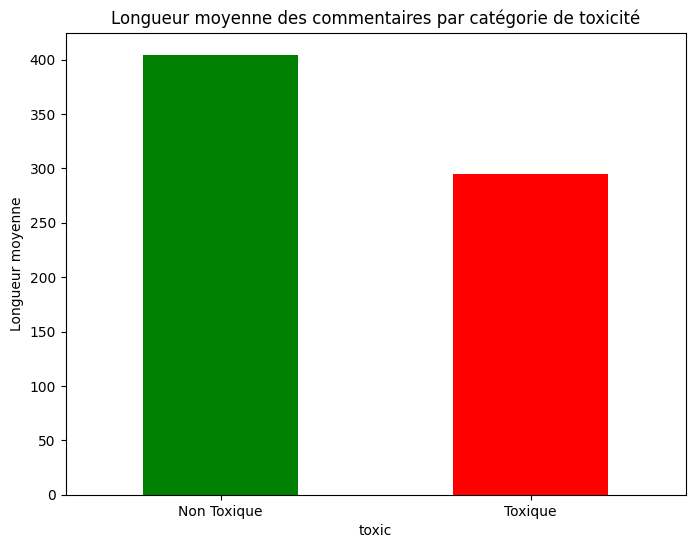

In [57]:
# Ajouter une colonne pour la longueur des commentaires
data['comment_length'] = data['comment_text'].apply(len)

# Afficher les statistiques sur la longueur des commentaires
print(data['comment_length'].describe())

# Afficher la longueur moyenne des commentaires en fonction de la toxicité
plt.figure(figsize=(8,6))
data.groupby('toxic')['comment_length'].mean().plot(kind='bar', color=['green', 'red'])
plt.title('Longueur moyenne des commentaires par catégorie de toxicité')
plt.ylabel('Longueur moyenne')
plt.xticks([0, 1], ['Non Toxique', 'Toxique'], rotation=0)
plt.show()


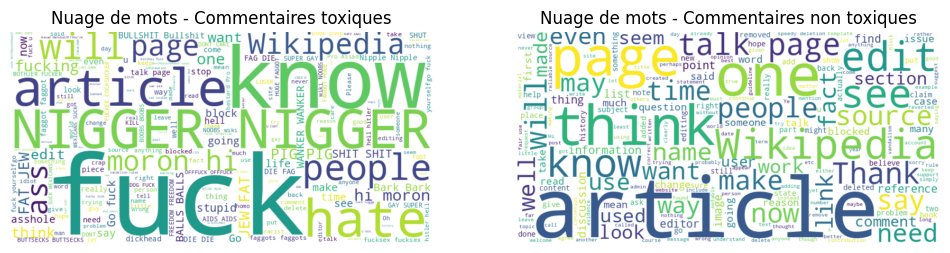

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nuage de mots pour les commentaires toxiques
toxic_comments = data[data['toxic'] == 1]['comment_text']
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_comments))

# Nuage de mots pour les commentaires non toxiques
non_toxic_comments = data[data['toxic'] == 0]['comment_text']
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_toxic_comments))

# Affichage des nuages de mots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots - Commentaires toxiques")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots - Commentaires non toxiques")

plt.show()


# Préparation des données

In [61]:
#on commence par nettoyer les commentaires
import re

# Fonction de nettoyage
def clean_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text)
    return text

# Appliquer le nettoyage à la colonne 'comment_text'
data['clean_comment'] = data['comment_text'].apply(clean_text)


In [62]:
#pour les stopword
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Fonction pour supprimer les stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

# Appliquer la suppression des stopwords
data['clean_comment'] = data['clean_comment'].apply(remove_stopwords)


In [63]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Appliquer la vectorisation sur les commentaires
X = vectorizer.fit_transform(data['clean_comment'])

# Afficher la forme du résultat
print(X.shape)


(159571, 5000)


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Appliquer la vectorisation sur les commentaires
X = tfidf_vectorizer.fit_transform(data['clean_comment'])

# Afficher la forme du résultat
print(X.shape)


(159571, 5000)


In [67]:
# Séparer les caractéristiques (X) et les labels (y)
X = tfidf_vectorizer.transform(data['clean_comment'])  # Utilisation de la vectorisation TF-IDF

# Choisir la colonne cible (par exemple, pour la toxicité globale)
#y = data['toxic']

# Sélectionner plusieurs labels si nécessaire
y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [68]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print("Ensemble d'entraînement:", X_train.shape)
print("Ensemble de test:", X_test.shape)


Ensemble d'entraînement: (127656, 5000)
Ensemble de test: (31915, 5000)


# Entraînement du modèle baseline

In [33]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='sigmoid')  # Activation sigmoïde pour classification multi-label
])

# Itération de la modélisation

In [ ]:
# Your Code